In [3]:
!pip install python-pptx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#General imports
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(666)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

from pathlib import Path
from datetime import datetime
import json
import os

In [5]:
cd /content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection

/content/drive/MyDrive/Giraffa Analytics/MRI-Blur-Detection


In [6]:
from Model.DataGenerator import DataGenerator
from Model.UncompiledModel import get_uncompiled_model
from Model.project_scripts import train_validation_test_split
from Model.project_scripts import model_json_loader
from Model.CustomCallbacks import PlottingCallback
from Model.CustomCallbacks import PptxReportCallback

from Model.Evaluation import print_model_metrics
from Model.Evaluation import get_mislabeled_images

In [7]:
#train_validation_test_split(val_percentage=0.15, test_percentage=0.05, trim_ends=25)

In [8]:
transform = False

In [9]:
training_generator = DataGenerator('train', transform=transform)
validation_generator = DataGenerator('validation', transform=transform)
testing_generator = DataGenerator('test', transform=transform)

In [10]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [11]:
# Design model
#GET MODEL NAME (the name is given by the time it started fitting)
CURRENT_TIME = datetime.now().strftime("%d-%m-%Y %H:%M")

#Create folder for the callbacks
os.mkdir(f'Callbacks/{CURRENT_TIME}')

model = get_uncompiled_model()

In [12]:
#We compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(
    #change these
    optimizer= optimizer,  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.Accuracy()],
)

optimizer_json = optimizer.get_config()

with open(f'Callbacks/{CURRENT_TIME}/optimizer.txt','w') as optimizer_file:
    json.dump(optimizer_json, optimizer_file)

In [13]:
#We save the summary of the model as a .txt file (PptxReportCallback will make use of it)
with open(f'Callbacks/{CURRENT_TIME}/model_summary.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'), line_length=120)

In [14]:
#Save config
config = model.get_config() #it is a dictionary which can be saved as a .json

model_json = model.to_json()
with open(f'Callbacks/{CURRENT_TIME}/model.json', "w") as json_file:
    json_file.write(model_json)
    
#CALLBACKS
#CSV LOGGER
logger_path = f'Callbacks/{CURRENT_TIME}/training.log'
logger_dir = os.path.dirname(logger_path)
csv_logger = CSVLogger(logger_path, append = False)

#ModelCheckpoint
checkpoint_path = f'Callbacks/{CURRENT_TIME}/model_checkpoint/training/'+'cp-{epoch:04d}.ckpt'
os.mkdir(f'Callbacks/{CURRENT_TIME}/model_checkpoint')
os.mkdir(f'Callbacks/{CURRENT_TIME}/model_checkpoint/training')
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

#PlottingCallback --custom callback
loss_acc_plotter = PlottingCallback(f'Callbacks/{CURRENT_TIME}')

#PpptxCallback
pptx_writer = PptxReportCallback(folder_path='Callbacks', model_dir=f'Callbacks/{CURRENT_TIME}')

#The callbacks will be executed in the order given below
model_callbacks = [csv_logger, model_checkpoint, loss_acc_plotter, pptx_writer]

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.12260, saving model to Callbacks/02-08-2022 13:27/model_checkpoint/training/cp-0001.ckpt
149/149 - 1791s - loss: 276.7730 - accuracy: 0.1401 - val_loss: 1.8708 - val_accuracy: 0.1226 - 1791s/epoch - 12s/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.12260
149/149 - 22s - loss: 0.3794 - accuracy: 0.0799 - val_loss: 2.0462 - val_accuracy: 0.0913 - 22s/epoch - 149ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.12260
149/149 - 17s - loss: 0.3609 - accuracy: 0.0914 - val_loss: 2.1667 - val_accuracy: 0.1082 - 17s/epoch - 115ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.12260 to 0.12500, saving model to Callbacks/02-08-2022 13:27/model_checkpoint/training/cp-0004.ckpt
149/149 - 17s - loss: 0.3501 - accuracy: 0.1036 - val_loss: 2.4295 - val_accuracy: 0.1250 - 17s/epoch - 116ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.12500 to 0.12740, saving model to Callbacks/02-08-2022 13:27/mo

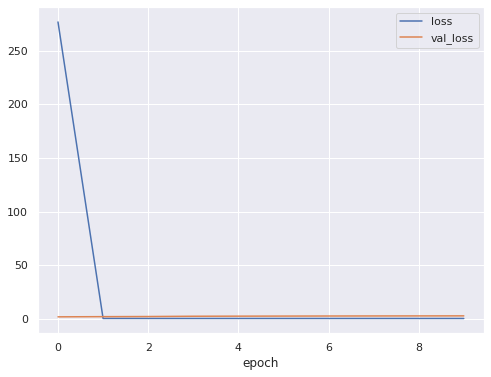

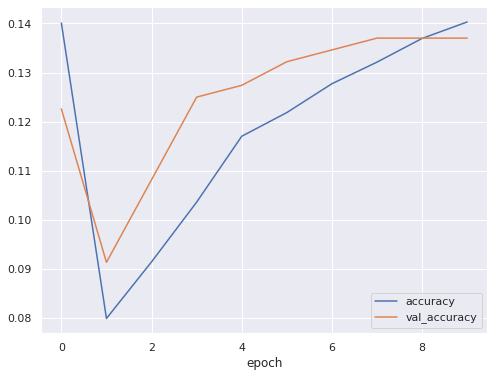

In [ ]:
#We fit the model
model.fit(training_generator,
          validation_data=validation_generator,
          verbose=2,
          epochs=10,
          callbacks = model_callbacks
         )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 16)      4624      
                                                                 
 flatten (Flatten)           (None, 1000000)           0         
                                                                 
 dense (Dense)               (None, 1)                 1000001   
                                                                 
Total params: 1,005,457
Trainable params: 1,005,457
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print_model_metrics(model, test_path='Data Splits/train_validation_test_split.csv')